# ADNI Class Comparison

In [1]:
%matplotlib inline

In [2]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import glob
import os.path as osp

from tqdm.notebook import tqdm, trange
from matplotlib.colors import CenteredNorm, TwoSlopeNorm

In [5]:
DATA_ROOT = "data/adni/"
DATA_AD = osp.join(DATA_ROOT, "AD")
DATA_CN = osp.join(DATA_ROOT, "CN")
AD_FILES = glob.glob(osp.join(DATA_AD, "*.nii.gz"))
CN_FILES = glob.glob(osp.join(DATA_CN, "*.nii.gz"))

In [6]:
# execute only with sufficient RAM

ad_images = [nib.load(fpath).get_fdata() for fpath in AD_FILES]
cn_images = [nib.load(fpath).get_fdata() for fpath in CN_FILES]
mu_ad = np.array(ad_images).mean(axis=0)
mu_cn = np.array(cn_images).mean(axis=0)

## Class Mean Difference

In [7]:
def get_mean(path):
    # only load one file at a time to reduce required RAM
    mu = 0
    n = len(glob.glob(path))
    for i, fpath in enumerate(glob.glob(path)):
        img = nib.load(fpath)
        x = img.get_fdata()
        mu += x
        # mu = (i/(i+1)) * mu + (1/ (i+1)) * x # running mean? ...wow, why so complicated?
    return mu / n

mu_ad = get_mean(osp.join(DATA_ROOT, "AD", "*.nii.gz"))
mu_cn = get_mean(osp.join(DATA_ROOT, "CN", "*.nii.gz"))

In [8]:
diff = mu_ad - mu_cn
vmax = diff.max()
vmin = diff.min()

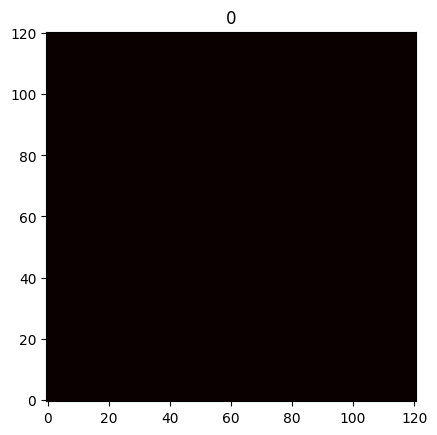

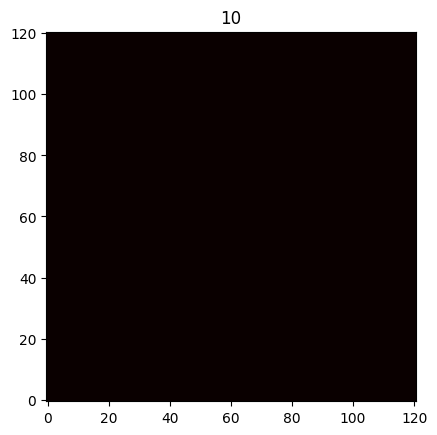

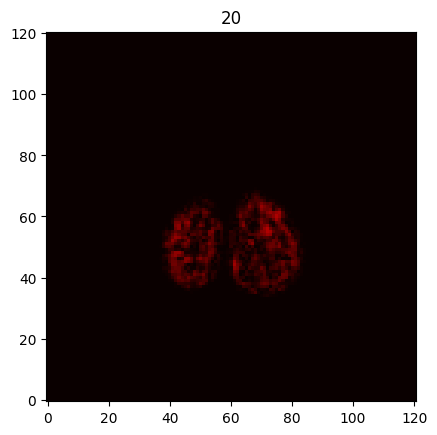

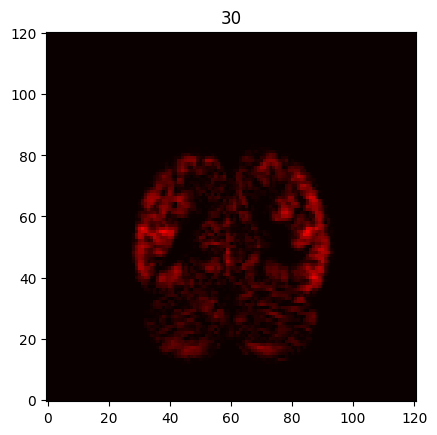

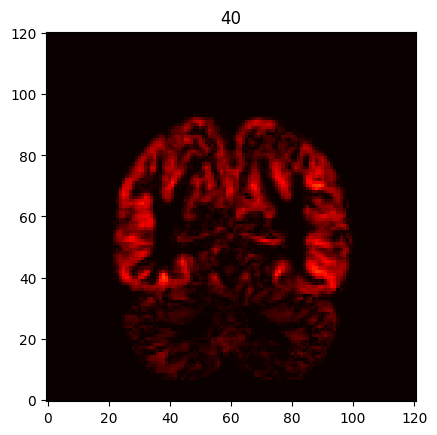

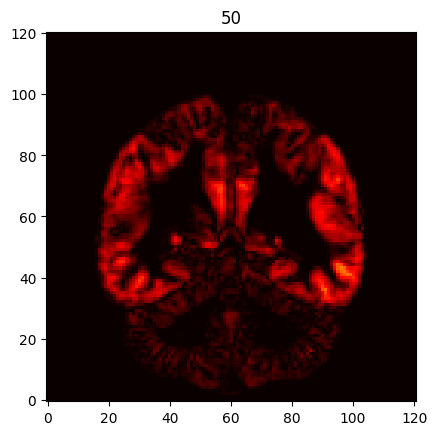

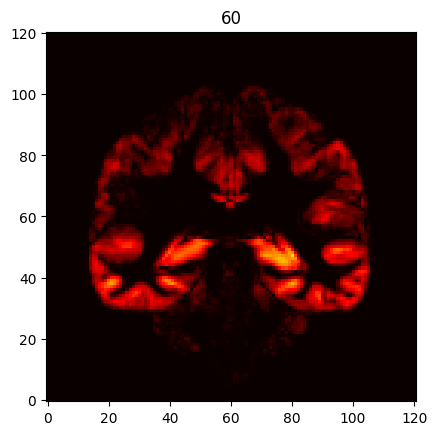

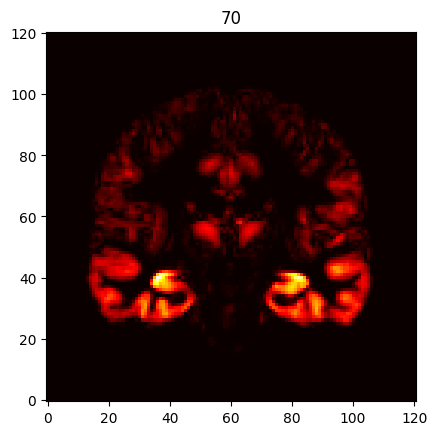

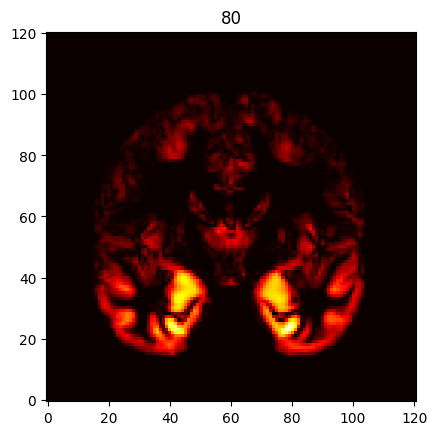

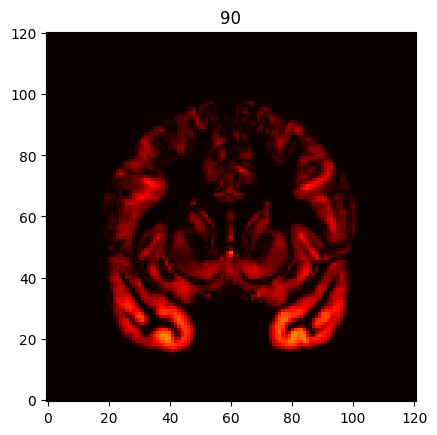

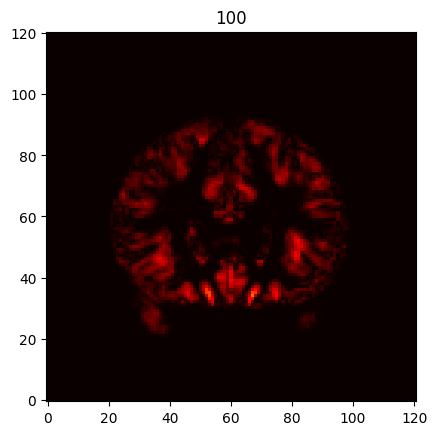

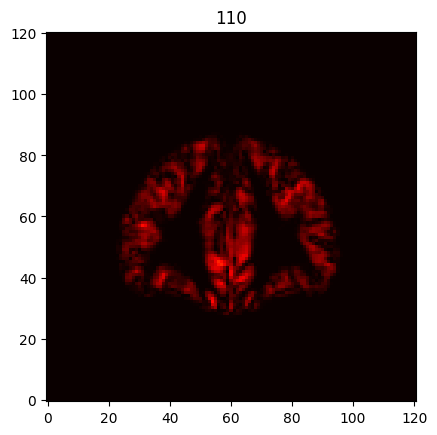

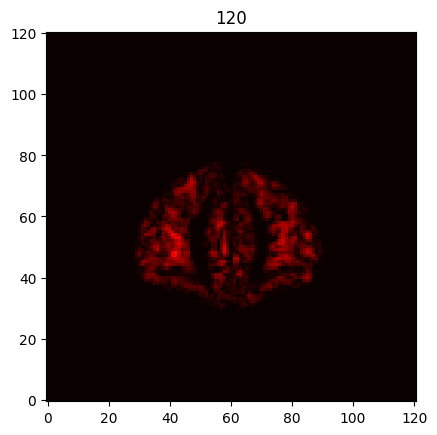

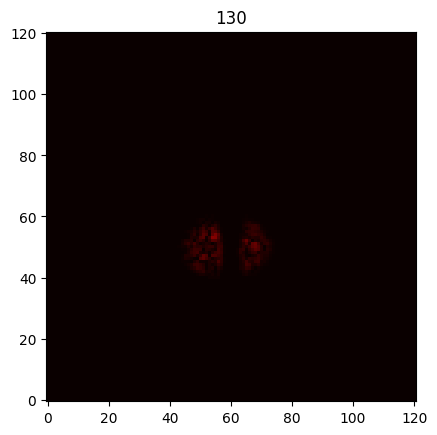

In [9]:
vmax = abs(diff).max()

for i in range(0,140,10):
    plt.figure()
    plt.title(str(i))
    plt.imshow(abs(diff[:,i,:].T), cmap="hot", origin="lower", vmax=vmax)

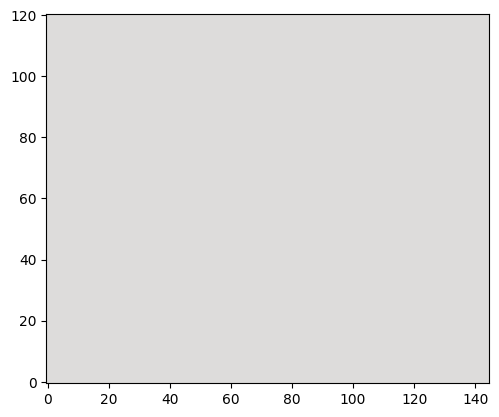

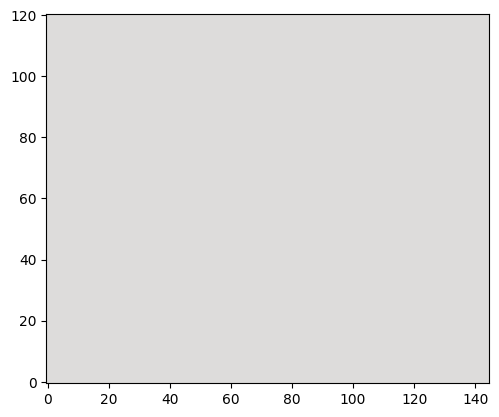

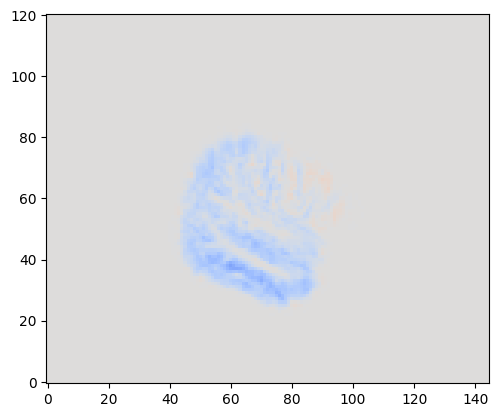

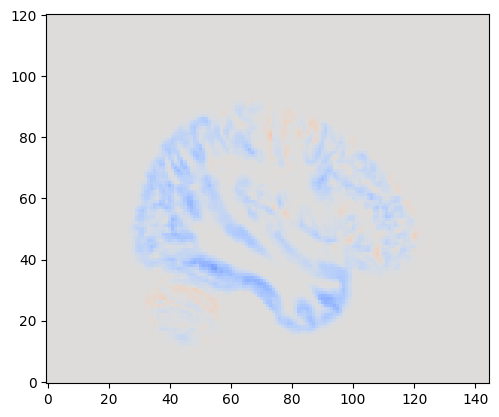

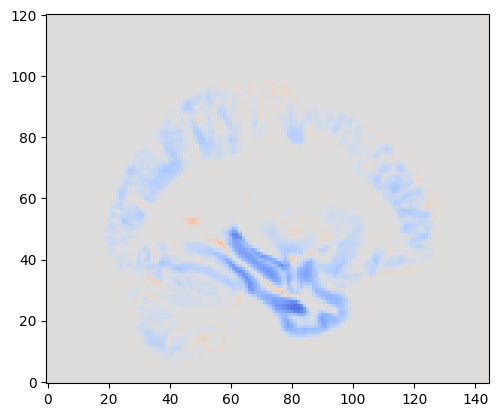

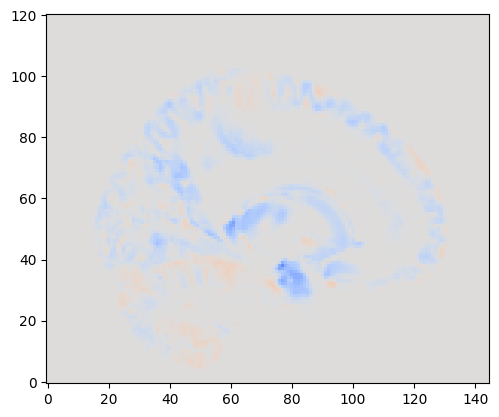

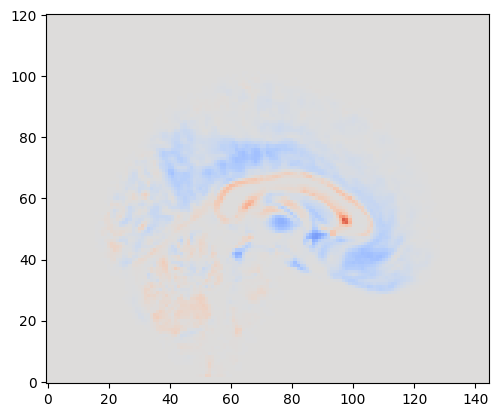

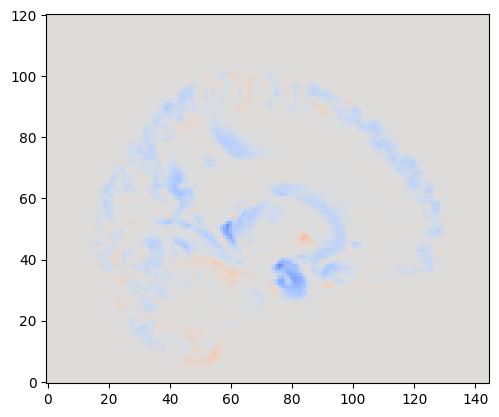

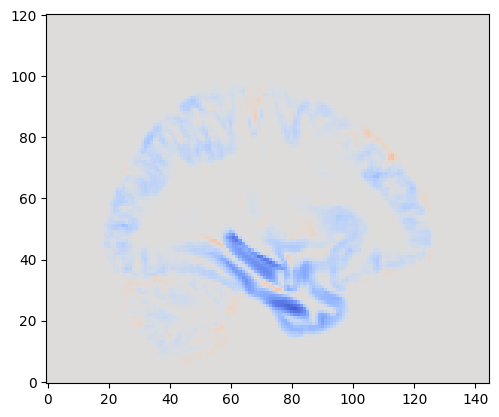

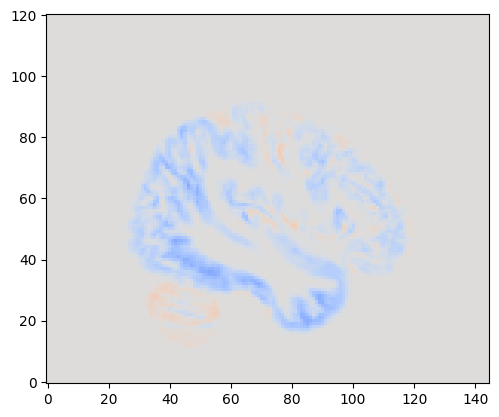

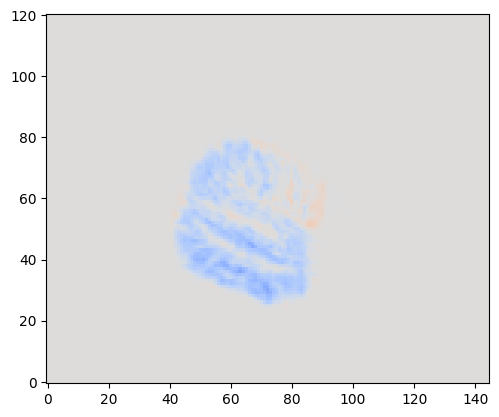

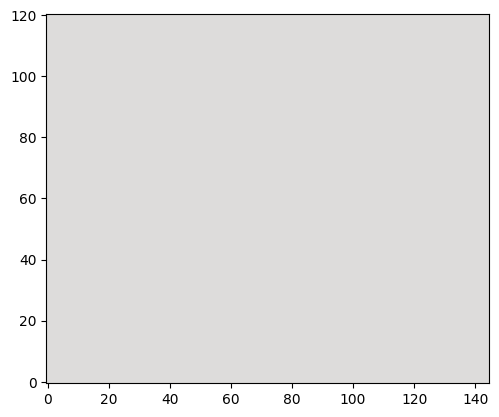

In [10]:
# CenteredNorm doesn't work correctly for some weird reason
# Workaround with TwoSlopeNorm
vmax = abs(diff).max()
norm = TwoSlopeNorm(vcenter=0, vmin=-vmax, vmax=vmax)

for i in range(0,120,10):
    plt.figure()
    plt.imshow(diff[i,:,:].T, cmap="coolwarm", origin="lower", norm=norm)

In [11]:
def plot_diff(diff, cmap="hot", norm=None, vmax=None):
    #fig = plt.figure()
    #subfigs = fig.subfigures(1, 3)
    slice_idxs = [
            [40, 50, 60],
            [90, 80, 70],
            [55, 40, 25],
        ]
    fig, axs = plt.subplots(3,3, figsize=(10,10))
    for i in range(3):
        #subfigs[i].suptitle("Sagittal")
        #axs = subfigs[i].subplots(3, 1)
        for j in range(3):
            axs[j,i].axis(False)
            idx = slice_idxs[i][j]
            d = np.rollaxis(diff, i, 0)
            axs[j, i].imshow(d[idx,:,:].T, origin="lower", cmap=cmap, vmax=vmax, norm=norm)
    
    # fig.suptitle("Class Mean Difference")

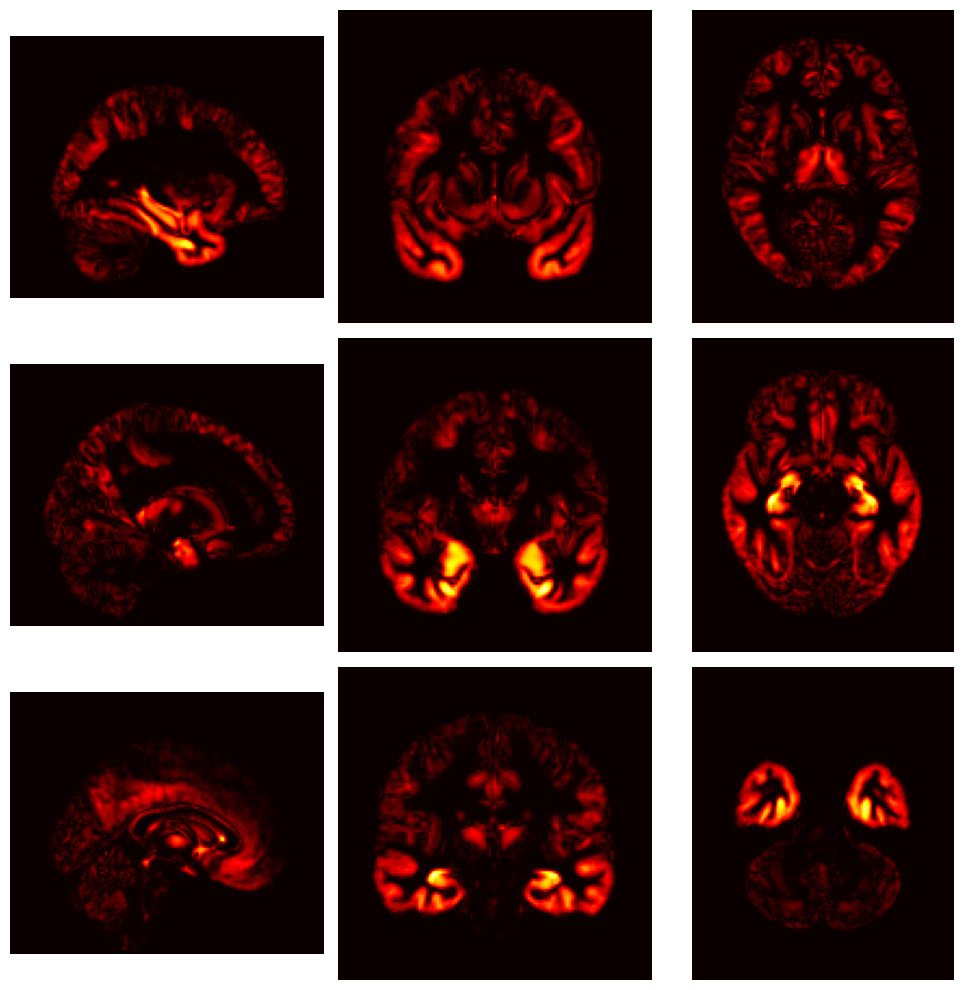

In [12]:
vmax=abs(diff).max()
plot_diff(abs(diff), vmax=vmax)
plt.tight_layout()
plt.show()

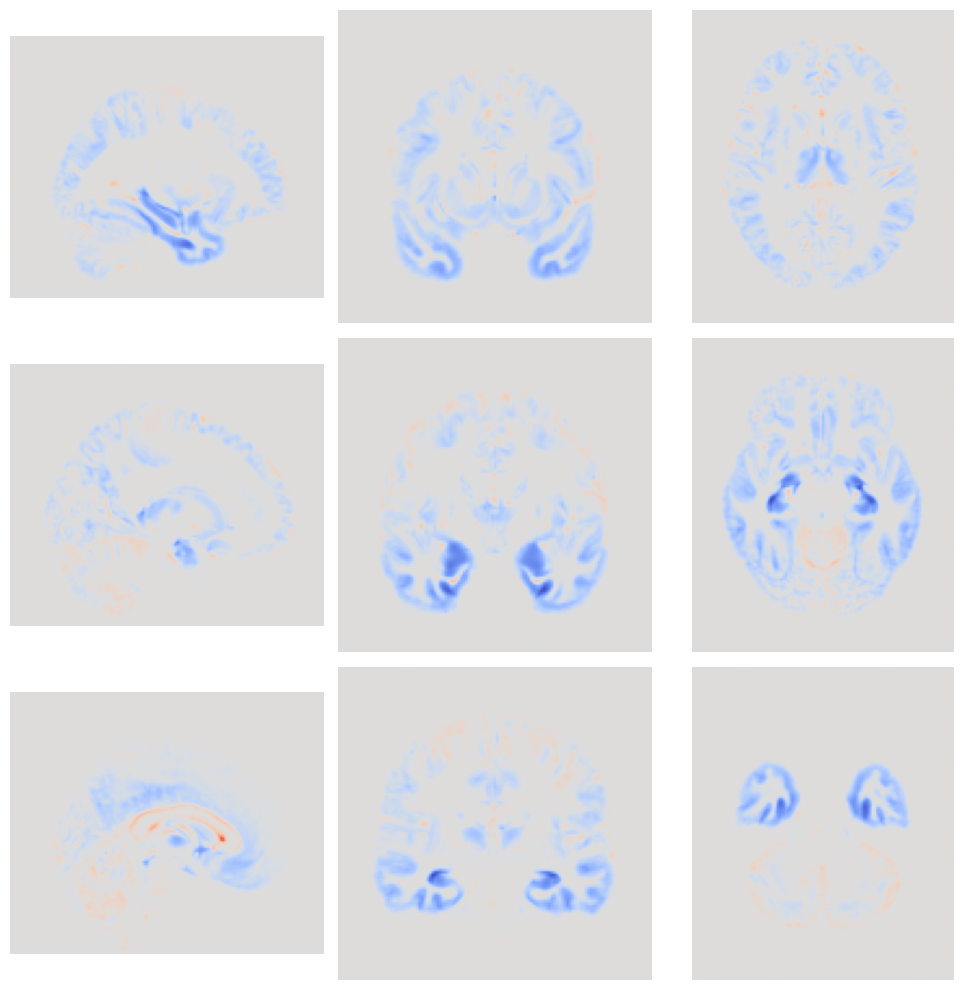

In [13]:
vmax=abs(diff).max()
norm = TwoSlopeNorm(vcenter=0, vmin=-vmax, vmax=vmax)

plot_diff(diff, cmap="coolwarm", norm=norm)
plt.tight_layout()
plt.show()

# Voxel-wise t-Test

- statistischer t-Test dient zum Überprüfen einer Hypothese
- Name kommt von studentischer t-Verteilung
- häufige Anwendung: Vergleich, ob Mittelwert zweier Stichpropen identisch sind
- im Kontext: Zwei Stichproben (AD, CN) aus einer Grundgesamtheit von MRT-Bildern
- Nullhypothese: Mittelwerte des Voxels von AD und CN sind identisch
- Alternativ-Hypothese: Mittelwerte des Voxels von AD und CN sind verschieden
- Grundidee: Differenz der Stichprobenmittelwerte, gewichtet bei Varianz und Größe der Stichproben
- t-Statistik: Umso Größer, je höher Differenz der Mittelwerte ist und umso kleiner, je größer Varianz der Stichproben sind
- "Große Varianz macht extreme Abweichungen in den Stichproben wahrscheinlicher"
- Nullhypothese wird akzeptiert, solange t-Wert ein bestimmtes Quantil nicht überschreitet
- p-Wert: Gibt Wahrscheinlichkeit zurück, dass für ein gewähltes Quantil diese Werte zu beobachten sind

In [14]:
from scipy.stats import ttest_ind

In [15]:
statistic, pvalue = ttest_ind(cn_images, ad_images)

0
10
20
30
40
50
60
70
80
90
100
110


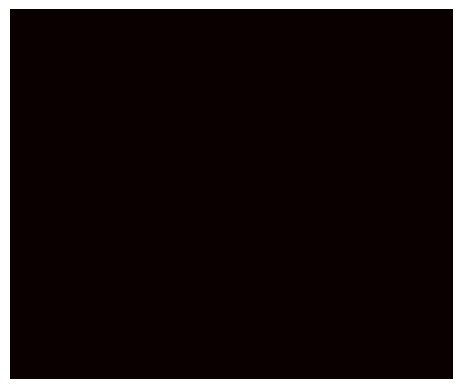

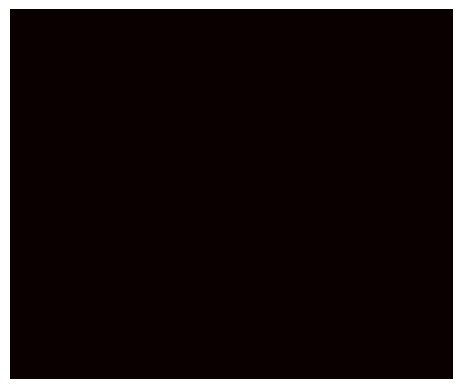

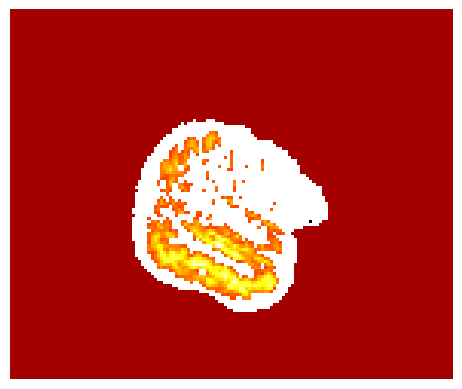

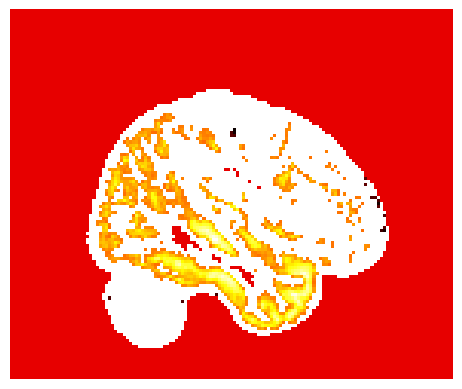

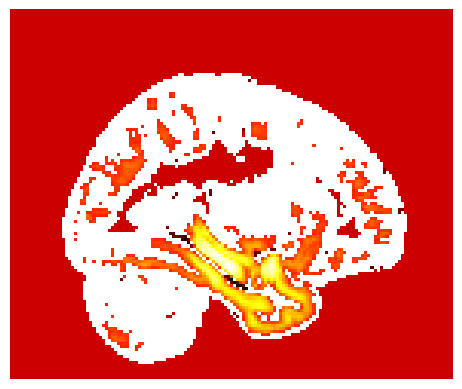

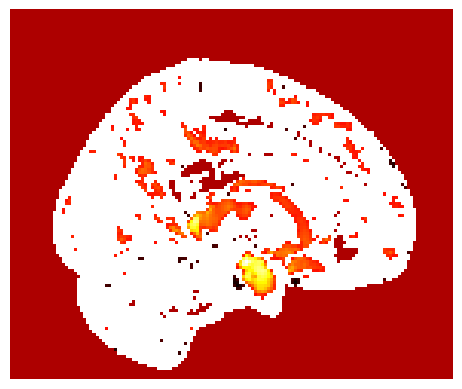

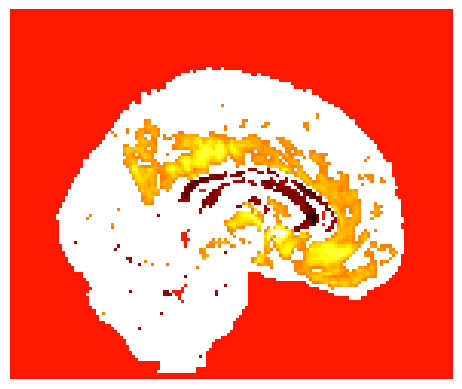

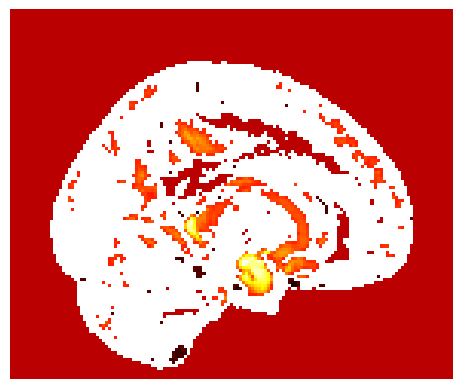

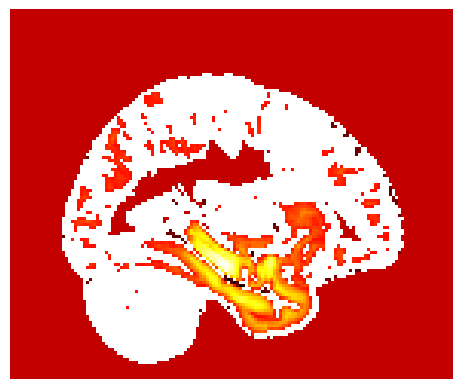

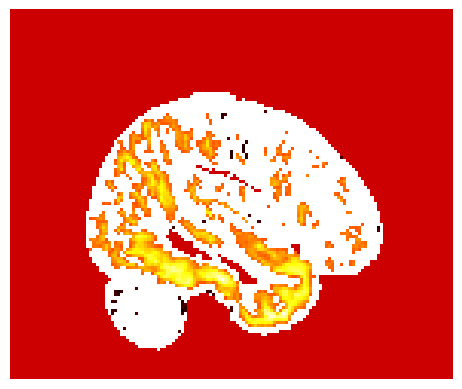

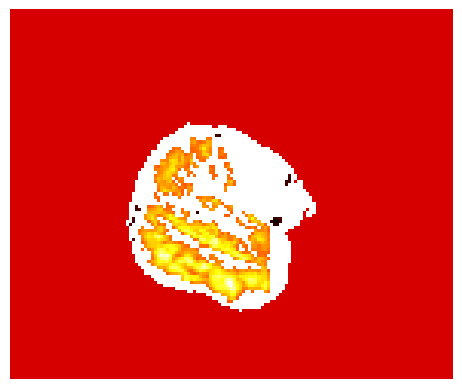

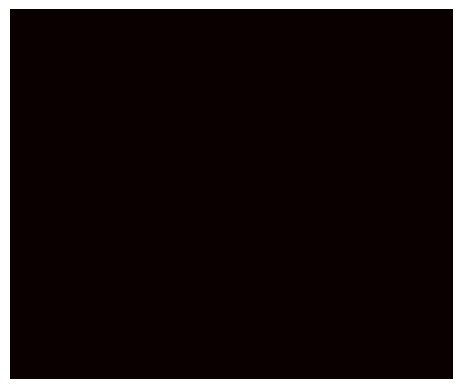

In [35]:
bg = nib.load(CN_FILES[0]).get_fdata()

for i in range(0, 120, 10):
    print(i)
    plt.figure()
    #plt.imshow(bg[:, :, i].T, cmap="gray", origin="lower")
    alpha = np.ones_like(pvalue)
    alpha[pvalue > 0.01] = 0
    #alpha = 1 - pvalue
    #alpha[np.isnan(alpha)] = 0
    #print(alpha[i,:,:].max())
    #plt.imshow(np.zeros_like(statistic[i,:,:].T), cmap="hot")
    plt.imshow(statistic[i,:, :].T, cmap="hot", origin="lower", alpha=alpha[i,:,:].T)
    #plt.imshow(statistic[:, :, i].T, cmap="hot", origin="lower", alpha=alpha[:,:,i].T)
    plt.axis('off')
    #plt.title(str(i))

In [17]:
mu = np.array(ad_images + cn_images).mean(0)
alpha = np.ones_like(pvalue)
alpha[pvalue > 0.01] = 0
s1 = 40
s2 = 70
s3 = 40

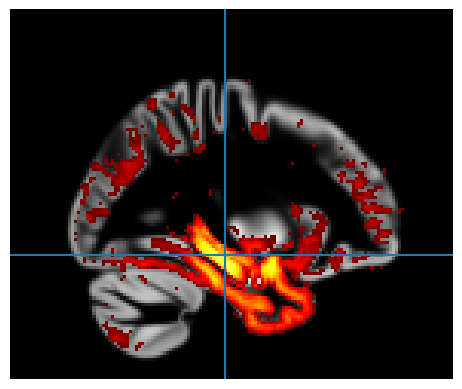

In [20]:
plt.figure()
plt.imshow(mu[s1,:,:].T, cmap="gray", origin="lower", interpolation="nearest")
plt.imshow(abs(statistic[s1,:,:]).T, vmin=0, vmax=18, cmap="hot", origin="lower", alpha=alpha[s1,:,:].T, interpolation="nearest")
plt.axis(False)
plt.axline((s2,0),(s2,1))
plt.axline((0,s3),(1,s3))
plt.savefig("figures/ttest_sagittal.png", bbox_inches="tight", transparent=True)
plt.show()

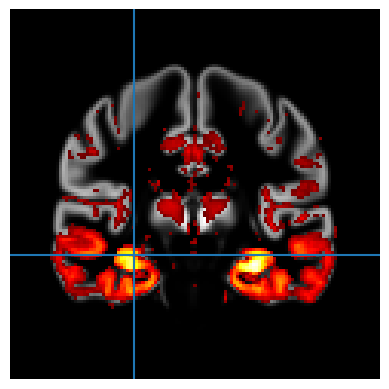

In [21]:
plt.figure()
plt.imshow(mu[:,s2,:].T, cmap="gray", origin="lower", interpolation="nearest")
plt.imshow(abs(statistic[:,s2,:]).T, vmin=0, vmax=18, cmap="hot", origin="lower", alpha=alpha[:,s2,:].T, interpolation="nearest")
plt.axis(False)
plt.axline((s1,0),(s1,1))
plt.axline((0,s3),(1,s3))
plt.savefig("figures/ttest_coronal.png", bbox_inches="tight", transparent=True)
plt.show()

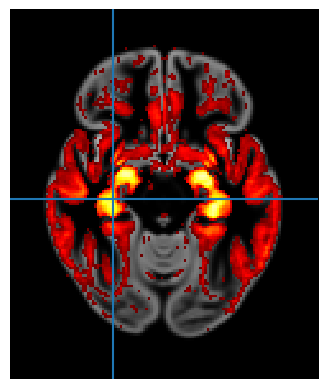

In [22]:
plt.figure()
plt.imshow(mu[:,:,s3].T, cmap="gray", origin="lower", interpolation="nearest")
plt.imshow(abs(statistic[:,:,s3]).T, vmin=0, vmax=18, cmap="hot", origin="lower", alpha=alpha[:,:,s3].T, interpolation="nearest")
plt.axis(False)
plt.axline((s1,0),(s1,1))
plt.axline((0,s2),(1,s2))
#plt.colorbar()
plt.savefig("figures/ttest_axial.png", bbox_inches="tight", transparent=True)
plt.show()

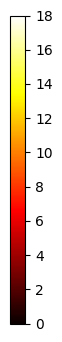

In [23]:
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

fig, ax = plt.subplots(figsize=(6,4))
plt.colorbar(ScalarMappable(Normalize(vmin=0,vmax=18),cmap="hot"), ax=ax)
ax.remove()
plt.savefig('figures/ttest_colorbar.png', bbox_inches='tight', transparent=True)

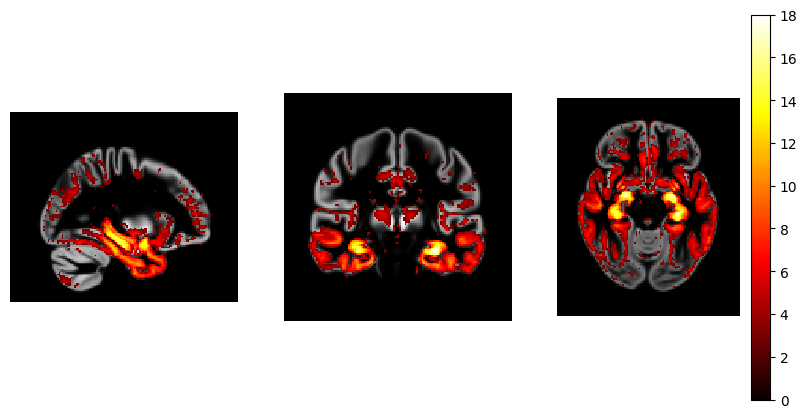

In [24]:
fig, axs = plt.subplots(1,3,figsize=(10,5))

for i in range(3):
    axs[i].axis(False)

axs[0].imshow(mu[s1,:,:].T, cmap="gray", origin="lower", interpolation="nearest")
axs[0].imshow(abs(statistic[s1,:,:]).T, vmin=0, vmax=18, cmap="hot", origin="lower", alpha=alpha[s1,:,:].T, interpolation="nearest")

axs[1].imshow(mu[:,s2,:].T, cmap="gray", origin="lower", interpolation="nearest")
axs[1].imshow(abs(statistic[:,s2,:]).T, vmin=0, vmax=18, cmap="hot", origin="lower", alpha=alpha[:,s2,:].T, interpolation="nearest")

axs[2].imshow(mu[:,:,s3].T, cmap="gray", origin="lower", interpolation="nearest")
im = axs[2].imshow(abs(statistic[:,:,s3]).T, vmin=0, vmax=18, cmap="hot", origin="lower", alpha=alpha[:,:,s3].T, interpolation="nearest")

plt.colorbar(im)
plt.show()

In [25]:
statistic[np.isnan(statistic)] = 0

In [26]:
statistic.min()

-10.85041701198819

In [27]:
statistic.max()

17.83250767445011

In [28]:
x = statistic[:,:,s3]

In [29]:
x[np.isnan(x)] = 0

In [30]:
x.min()

-4.716594142471886

In [31]:
x.max()

16.673773769472895